In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.figure_factory as ff

data_covid19 = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df_covid = pd.read_csv(data_covid19)
data_population = "https://raw.githubusercontent.com/jhu-business-analytics/covid-19-case-python-data-analysis/master/original_data_files/ACSST1Y2018.S0101_data_with_overlays_2020-04-02T080504.csv"
df_population = pd.read_csv(data_population)
data_state_geocodes = "https://raw.githubusercontent.com/jhu-business-analytics/covid-19-case-python-data-analysis/master/original_data_files/state-geocodes-v2018.csv"
df_states = pd.read_csv(data_state_geocodes)
data_all_geocodes = "https://raw.githubusercontent.com/jhu-business-analytics/covid-19-case-python-data-analysis/master/original_data_files/all-geocodes-v2018.csv"
df_county = pd.read_csv(data_all_geocodes)
data_hospitals = "https://raw.githubusercontent.com/jhu-business-analytics/covid-19-case-python-data-analysis/master/original_data_files/Hospitals.csv"
df_hospitals = pd.read_csv(data_hospitals)




In [2]:
df_population.columns = df_population.iloc[0]
df_population = df_population[1:]
margin_error = df_population.columns.str.startswith("Margin of Error!!")
df_pop_values = df_population.loc[:, ~margin_error]
df_us_pop = df_pop_values.drop(columns=df_pop_values.columns[(df_pop_values == '(X)').any()])
df_us_pop.columns = df_us_pop.columns.str.strip("Estimate!!")
df_us_pop.columns = df_us_pop.columns.str.replace("!!Total population", "")
uspop_col = ['d',
             'Geographic Area N',
             'Total',
             'Male',
             'Female',
             'Total!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Male!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Female!!SELECTED AGE CATEGORIES!!Under 18 year',
             'Total!!SELECTED AGE CATEGORIES!!60 years and over',
             'Male!!SELECTED AGE CATEGORIES!!60 years and over',
             'Female!!SELECTED AGE CATEGORIES!!60 years and over',
             'Total!!SUMMARY INDICATORS!!Median age (years)',
             'Total!!SUMMARY INDICATORS!!Sex ratio (males per 100 females)',
             'Total!!SUMMARY INDICATORS!!Age dependency ratio',
             'Total!!SUMMARY INDICATORS!!Old-age dependency ratio',
             'Total!!SUMMARY INDICATORS!!Child dependency ratio',
            ]
df_us_pop_filter = df_us_pop.filter(items = uspop_col)
df_us_pop_filter.columns = df_us_pop_filter.columns.str.replace("!!SELECTED AGE CATEGORIES!!", " ")
df_us_pop_filter.columns = df_us_pop_filter.columns.str.replace("Total!!SUMMARY INDICATORS!!", "")


In [3]:
df_states = pd.read_csv(data_state_geocodes, skiprows = 5)
df_county = pd.read_csv(data_all_geocodes, skiprows = 4)
df_county = df_county[df_county["County Code (FIPS)"] != 0]
df_county[["State Code (FIPS)", "County Code (FIPS)"]] = df_county[["State Code (FIPS)", "County Code (FIPS)"]].astype(str)
df_county["State Code (FIPS)"] = df_county["State Code (FIPS)"].str.zfill(2)
df_county["County Code (FIPS)"] = df_county["County Code (FIPS)"].str.zfill(3)
df_county["full_county_fips"] = df_county["State Code (FIPS)"] + df_county["County Code (FIPS)"]


In [4]:
#Merging
df_states["State (FIPS)"] = df_states["State (FIPS)"].astype(str)
df_states["State (FIPS)"] = df_states["State (FIPS)"].str.zfill(2)
df_county = pd.merge(df_county, 
                     df_states[["State (FIPS)", "Name"]], 
                     how = "left", 
                     left_on = "State Code (FIPS)", 
                     right_on = "State (FIPS)")

df_county["county_state_name"] = df_county["Area Name (including legal/statistical area description)"] + ", " + df_county["Name"]


In [5]:
df_county_pop = pd.merge(df_us_pop_filter,
                         df_county[["county_state_name", "full_county_fips"]],
                         how = "left",
                         left_on = "Geographic Area N",
                         right_on = "county_state_name"
                        )
df_county_pop = df_county_pop[df_county_pop["full_county_fips"].notnull()]
int_list = [
 'Total',
 'Male',
 'Female',
 'Total Under 18 year',
 'Male Under 18 year',
 'Female Under 18 year',
 'Total 60 years and over',
 'Male 60 years and over',
 'Female 60 years and over']
float_list = [ 
    'Median age (years)',
    'Sex ratio (males per 100 females)',
    'Age dependency ratio',
    'Old-age dependency ratio',
    'Child dependency ratio']
df_county_pop[int_list] = df_county_pop[int_list].astype(int)
df_county_pop[float_list] = df_county_pop[float_list].astype(float)
df_county_pop["percent_under18"] = (df_county_pop["Total Under 18 year"]/df_county_pop["Total"])*100
df_county_pop["percent_over60"] = (df_county_pop["Total 60 years and over"]/df_county_pop["Total"])*100


In [6]:
df_hospitals= df_hospitals[df_hospitals["COUNTYFIPS"] != "NOT AVAILABLE"]
df_hospitals = df_hospitals[df_hospitals["COUNTYFIPS"].notnull()]
df_hospitals = df_hospitals[df_hospitals["BEDS"] != -999] 
#^This line is not getting rid of -999 for some reason. There are also additional negative values


In [7]:
df_county_hospitals = df_hospitals.groupby("COUNTYFIPS").agg({"BEDS": "sum", 
                                                                "NAME": "count"}).reset_index()
df_county_hospitals = df_county_hospitals.rename(columns = {"NAME": "hospital_count",
                                                           "BEDS": "hospital_bed_count"})
df_county_health = pd.merge(df_county_pop,
                           df_county_hospitals,
                           how = "left",
                           left_on = "full_county_fips",
                           right_on = "COUNTYFIPS")
df_county_health = df_county_health[df_county_health["COUNTYFIPS"].notnull()]
df_county_health.to_csv("us_county_population_hospital_data_2018.csv")

In [14]:
df_total_pop = df_county_health.sort_values(by = "Total", ascending = False)
df_total_top20 = df_total_pop.head(20)
bar_total_pop = px.bar(df_total_top20,
                   x = "Geographic Area N",
                   y = "Total",
                   title = "US Counties with the Highest Total Population",
                   labels = {"Geographic Area N": "County, State Name", "Total": "Total Population"})

In [30]:
bubble_u18_o60 = px.scatter(df_county_health,
                            x = "percent_over60",
                            y = "percent_under18",
                            size = "hospital_bed_count",
                            hover_data = ['Geographic Area N',"Total"],
                            title = "Percentage of Population Under 18 and Over 60 in US Counties",
                            labels = {"Geographic Area N": "County, State Name",
                                      "Total": "Total Population",
                                      "percent_over60": "Percent of County Population over 60 years old",
                                      "percent_under18": "Percent of County Population under 18 years old"})
df_county_health["hospitalbeds_per10000"] = (df_county_health["hospital_bed_count"]/df_county_health["Total"])*1000
bubble_u18_o60_beds = px.scatter(df_county_health,
                            x = "percent_over60",
                            y = "percent_under18",
                            size = "hospitalbeds_per10000",
                            hover_data = ['Geographic Area N',"Total"],
                            title = "Percentage of Population Under 18 and Over 60 in US Counties",
                            labels = {"Geographic Area N": "County, State Name",
                                      "Total": "Total Population",
                                      "percent_over60": "Percent of County Population over 60 years old",
                                      "percent_under18": "Percent of County Population under 18 years old",
                                     "hospitalbeds_per10000": "Number of Hospital Beds per 1000 People"})

df_covid_apr10 = df_covid[df_covid["date"]== "2020-04-10"]
df_covid_apr10 = df_covid_apr10[df_covid_apr10["fips"].notnull()]


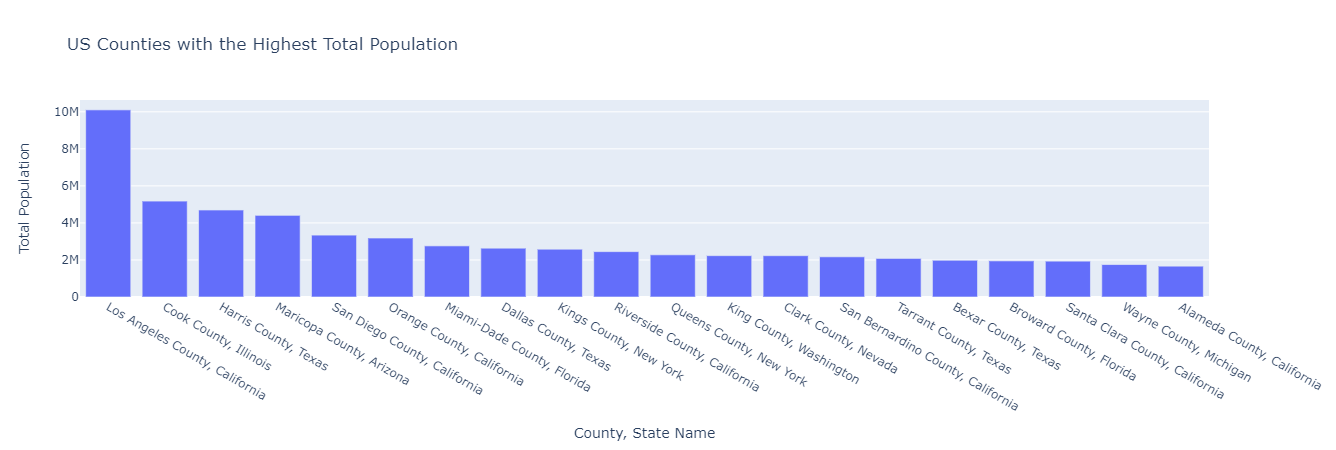

In [22]:
bar_total_pop

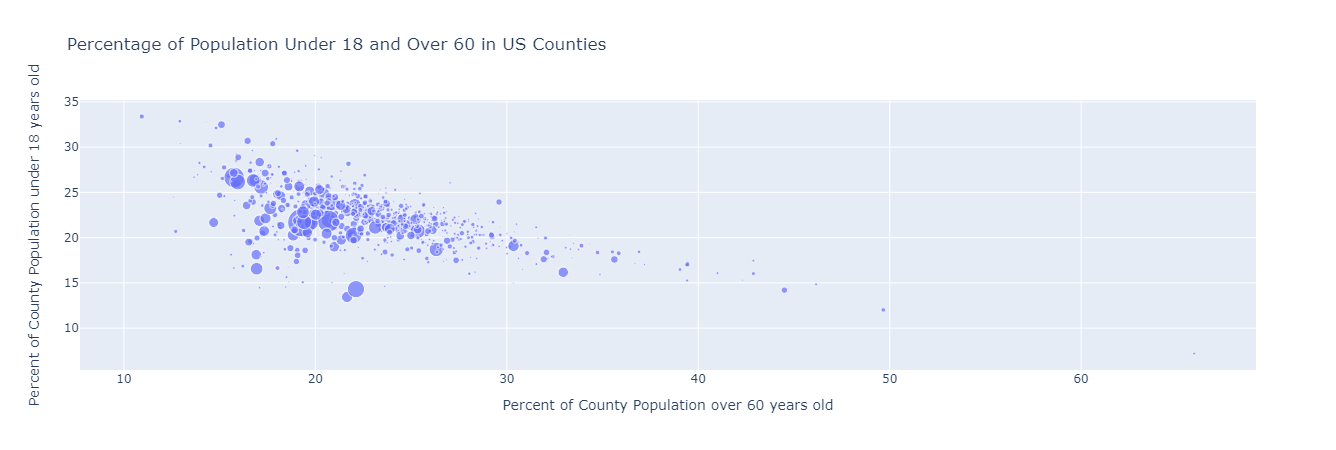

In [16]:
bubble_u18_o60

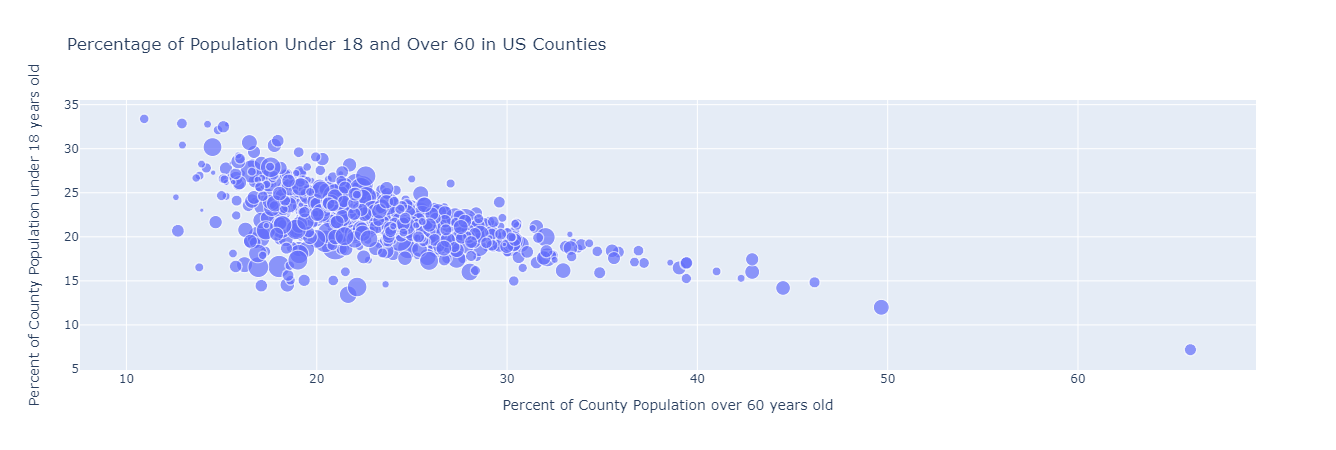

In [23]:
bubble_u18_o60_beds

In [31]:
# convert fips number to int and then string
df_covid_apr10["fips"] = df_covid_apr10["fips"].astype(int)
df_covid_apr10["fips"] = df_covid_apr10["fips"].astype(str)
df_covid_apr10["fips"] = df_covid_apr10["fips"].str.zfill(5)
df_county_health = pd.merge(df_county_health,
                           df_covid_apr10[["fips", "cases", "deaths"]],
                           how = "left",
                           left_on = "full_county_fips",
                           right_on = "fips")
df_county_health["cases_per1000"] = (df_county_health["cases"]/df_county_health["Total"])*1000
df_county_health["deaths_per1000"] = (df_county_health["deaths"]/df_county_health["Total"])*1000
covid_corr = df_county_health.corr()

covid_corr

,Total,Male,Female,Total Under 18 year,Male Under 18 year,Female Under 18 year,Total 60 years and over,Male 60 years and over,Female 60 years and over,Median age (years),...,cases_x,deaths_x,cases_y,deaths_y,cases_x,deaths_x,cases_y,deaths_y,cases,deaths
Total,1.000000,0.999857,0.999866,0.993070,0.993071,0.993004,0.986421,0.986031,0.986037,-0.117325,...,0.483454,0.424232,0.483454,0.424232,0.483454,0.424232,0.483454,0.424232,0.483454,0.424232
Male,0.999857,1.000000,0.999445,0.993453,0.993486,0.993353,0.985345,0.985358,0.984637,-0.119001,...,0.479701,0.420553,0.479701,0.420553,0.479701,0.420553,0.479701,0.420553,0.479701,0.420553
Female,0.999866,0.999445,1.000000,0.992429,0.992399,0.992396,0.987192,0.986414,0.987122,-0.115671,...,0.486986,0.427705,0.486986,0.427705,0.486986,0.427705,0.486986,0.427705,0.486986,0.427705
Total Under 18 year,0.993070,0.993453,0.992429,1.000000,0.999969,0.999967,0.967238,0.967666,0.966206,-0.151806,...,0.464077,0.405304,0.464077,0.405304,0.464077,0.405304,0.464077,0.405304,0.464077,0.405304
Male Under 18 year,0.993071,0.993486,0.992399,0.999969,1.000000,0.999872,0.967255,0.967718,0.966194,-0.151629,...,0.463964,0.405233,0.463964,0.405233,0.463964,0.405233,0.463964,0.405233,0.463964,0.405233
Female Under 18 year,0.993004,0.993353,0.992396,0.999967,0.999872,1.000000,0.967157,0.967549,0.966154,-0.151979,...,0.464163,0.405352,0.464163,0.405352,0.464163,0.405352,0.464163,0.405352,0.464163,0.405352
Total 60 years and over,0.986421,0.985345,0.987192,0.967238,0.967255,0.967157,1.000000,0.999515,0.999683,-0.027644,...,0.511050,0.457416,0.511050,0.457416,0.511050,0.457416,0.511050,0.457416,0.511050,0.457416
Male 60 years and over,0.986031,0.985358,0.986414,0.967666,0.967718,0.967549,0.999515,1.000000,0.998413,-0.023275,...,0.504289,0.451351,0.504289,0.451351,0.504289,0.451351,0.504289,0.451351,0.504289,0.451351
Female 60 years and over,0.986037,0.984637,0.987122,0.966206,0.966194,0.966154,0.999683,0.998413,1.000000,-0.031154,...,0.516262,0.462093,0.516262,0.462093,0.516262,0.462093,0.516262,0.462093,0.516262,0.462093
Median age (years),-0.117325,-0.119001,-0.115671,-0.151806,-0.151629,-0.151979,-0.027644,-0.023275,-0.031154,1.000000,...,-0.009021,0.007299,-0.009021,0.007299,-0.009021,0.007299,-0.009021,0.007299,-0.009021,0.007299


In [32]:
county_covid19_heatmap = ff.create_annotated_heatmap(z = covid_corr.values, 
                                       x=list(covid_corr.columns), 
                                       y=list(covid_corr.index), 
                                       annotation_text=covid_corr.round(2).values, 
                                       showscale = True 
                                       )

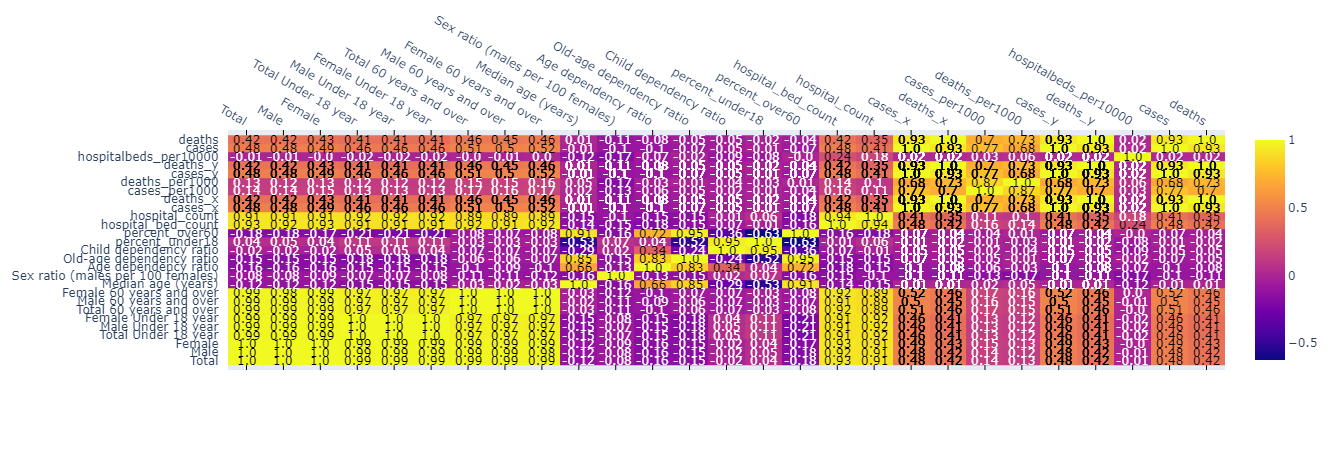

In [33]:
county_covid19_heatmap